In [1]:
import sys
import pickle
from scipy import signal
from scipy import stats
import numpy as np
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import cohen_kappa_score

import math
from collections import OrderedDict


import matplotlib.pyplot as plt

sys.path.append('D:\Diamond\code')
from csp_james_2 import *

sys.path.append('D:\Diamond\code')
from thesis_funcs_19_03 import *

import torch
import torch.nn as nn
import torch.nn.functional as nnF
import torch.optim as optim
from torch.autograd import Variable
from torch.optim import lr_scheduler

import csv
from random import randint
import random
import datetime
import scipy

In [53]:
save_root  = 'E:\\Diamond\\own_expo\\pilot_test\\'
config_root= 'E:\\Diamond\\bci_iv\\MODELS\\fbcsp_mibif_cnn\\2a\\configs\\'


k_fold = 5


# initialize csp
m = 2# m is Nw in the paper "learning temporal information for brain-copmuter interface, Sakhavi et.al"
n_components = 2 * m  # pick some components
down_sample_step = 10 #Hilbert evelope
# select Ns pairs of csp filters
Ns = 4

CLASSES =[0,1]

C_OVR = [0,1]

balance_classes = 1


########################################################################################################################
                                            # DEFINE FILTER BANK
########################################################################################################################
#Filter Bank
FB = [[4., 8.], [8., 12.], [12., 16.], [16., 20.], [20., 24.], [24., 28.], [28., 32.], [32., 36.], [36., 40.]]
FB = np.array(FB)

#argumaents for Chebyl II filtering
# Nyquist frequency

# min. attenuation in stop band
gstop = 45
# max. attenuation in passband
gpass= 5 


EEG_PERIOD = [[1,2.5]]#actual MI eeg period, from 0.5s after cue to end of MI at 4 seconds after cue onset
FS = [512]


to_center_matrix = 0
calc_kl_d = 0
calc_mi_discrim  =0

In [41]:
# read _lambda values
with open(config_root +'_lambda_config.csv', mode = 'r') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter = ',')
    for row in csv_reader:
        _lambda_list_str = row[1:]
csv_file.close()        

#create _lambda value in list
_lambda_list = []
for i in _lambda_list_str:
    _lambda_list.append(float(i))

# Make training and evaluation sets

In [42]:
def seperate_train_eval_ind(EEG_MI_RAW_load, LABELS_load):
    
    #fist half of recording is training, second half is evaluation
    train_set_ind = np.arange(0, int(len(LABELS_load)/2))
    eval_set_ind = np.arange(int(len(LABELS_load)/2), int(len(LABELS_load)))

    EEG_MI_RAW_T = EEG_MI_RAW_load[train_set_ind]
    EEG_MI_RAW_E = EEG_MI_RAW_load[eval_set_ind]
    LABELS_load_T = LABELS_load[train_set_ind]
    LABELS_load_E = LABELS_load[eval_set_ind]
    
    return EEG_MI_RAW_T, LABELS_load_T, EEG_MI_RAW_E, LABELS_load_E

In [43]:
np.shape(EEG_filt_FB_go)

(9, 60, 16, 512)

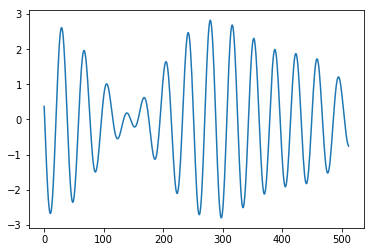

In [37]:
plt.plot(EEG_filt_FB_go[2,0,0])

In [38]:
FB

array([[ 4.,  8.],
       [ 8., 12.],
       [12., 16.],
       [16., 20.],
       [20., 24.],
       [24., 28.],
       [28., 32.],
       [32., 36.],
       [36., 40.]])

In [10]:
int(16<17)

1

In [6]:
2304/FS[0]

4.5

In [44]:
def calc_k_covs_all_fold_own_expo(EEG_extract_raw, LABELS, portion, k_file_root, balance_classes, FB,  gpass, gstop, fs, eeg_period, 
                             k_fold, C_OVR, load_idx, cv_train_size, calc_covs_all_fd = 1, to_center_matrix = 0):
    
    """
    #filename_T = 'B0'+str(subject)+'T'
    #ilename_save = filename
    #rint (filename_save)

    #k_file_root  = 'E:\\Diamond\\bci_iv\\MODELS\\fbcsp_mibif_cnn\\2a\\AUTORUN_50sel\\' + filename_T + '\\4s\\cv_30\\'
    ########################################################################################################################
                                                        #LOAD DATA
    ########################################################################################################################
    #load raw eeg and labels
    EEG_extract_raw = pickle.load(open(raw_data_root
                                                            + filename_T + '.pickle', 'rb'),encoding='iso-8859-1')
    #Class labels
    LABELS_raw = pickle.load(open(raw_data_root
                                                        + filename_T + "_LABELS.pickle", 'rb'), encoding='iso-8859-1')


    LABELS = LABELS_raw - 1 #already in 1,2,3,4, the labels are. but we nned them to be likw 0,1,2,3
    #LABELS = LABELS_raw
    """
    C_labels = []

    for c_ovr in C_OVR:
        c_label = np.where(LABELS == c_ovr)[0]
        #random.shuffle(c_label)
        c_label_p = c_label[0:int(portion*len(c_label))]
        
        C_labels = C_labels + c_label_p.tolist()
        
    C_labels= np.array(C_labels)
        
    EEG_extract_raw = EEG_extract_raw[C_labels, :]
    LABELS = LABELS[C_labels]



    #RUN THIS CODE ONLY ONCE, LABELS0 is the original labels, and LABELS will be changed in one-versus-rest strategy, later
    LABELS0 = LABELS.copy()





    ########################################################################################################################
                                        #APPLY FILTER BANK
    ########################################################################################################################
    
    clip_before_filter = 1
    if clip_before_filter:
        EEG_extract_raw = EEG_extract_raw[:,:, int(eeg_period[0]*fs):int(eeg_period[1]*fs)]
    
    
    
    #Store Filter bank filtered raw EEG data, in the shape of num_filter_bank X num_trials X num_chanl X num_samples
    #initiate empty matrix
    EEG_filt_FB_L = np.empty( [len(FB), 
                             np.shape(EEG_extract_raw)[0], np.shape(EEG_extract_raw)[1],np.shape(EEG_extract_raw)[2]] )

    Nf = fs / 2.
    for fb in range (0, len(FB)):
        passband = FB[fb]
        stopband = FB[fb] + np.array([-2., +2.])

        EEG_filt_FB_L[fb] = filter_signal(EEG_extract_raw, passband, stopband, Nf, gpass, gstop)


    

    #elimintae the start and end 0.5 secs, due to filter disturbance
    #EEG_filt_FB = EEG_filt_FB_L[:, :, :, int(0.5*fs):int(-0.5*fs)]
    EEG_filt_FB = EEG_filt_FB_L

    if to_center_matrix == 1:
        EEG_filt_FB = center_matrix(EEG_filt_FB)

    if clip_before_filter == 0:
        #trake only the MI 3.5 seconds
        EEG_filt_FB_go = EEG_filt_FB[:,:,:,int(eeg_period[0]*fs):int(eeg_period[1]*fs)]
    else:
        EEG_filt_FB_go = EEG_filt_FB
    LABELS0_go = LABELS0.copy()


    if load_idx == 0:
        TRAIN_IDX,  TEST_IDX = cv_train_test_strat(k_fold, cv_train = cv_train_size, LABELS0 = LABELS0_go, C_OVR = C_OVR)
    elif load_idx == 1:
        TRAIN_IDX = pickle.load(open(k_file_root  + '\\TRAIN_IDX.pickle', 'rb'))
        TEST_IDX = pickle.load(open(k_file_root + '\\TEST_IDX.pickle', 'rb'))

    Train_idx = ovr_train_ind(k_fold, C_OVR, LABELS0_go, TRAIN_IDX, balance_classes)
    ########################################################################################################################
    
    if calc_covs_all_fd == 1:
    
        COVS_AL_FD = []
        for fold in range (0, k_fold):
            Covs = np.zeros((len(FB), len(C_OVR), 2, np.shape(EEG_filt_FB_go)[2], np.shape(EEG_filt_FB_go)[2]))
            for c_ovr in C_OVR:
                train_idx = Train_idx[fold][c_ovr]

                #training labels
                LABELS_train = LABELS0_go[train_idx]
                #binaritize LABELS_train so that "one" is class 0, and "rest" is class 1
                LABELS_train = make_ovr_01_labels(LABELS_train, c_ovr)

                #training eeg signals
                EEG_train_FB = EEG_filt_FB_go[:,train_idx,:]


                for fb in range (0, len(FB)):
                    covs = covs_classes(_classes = [0,1], n_ch = np.shape(EEG_train_FB)[2], X = EEG_train_FB[fb], y = LABELS_train)
                    Covs[fb][c_ovr] = covs

            COVS_AL_FD.append(Covs)
    
    elif calc_covs_all_fd == 0:
        COVS_AL_FD = None        
    
    return COVS_AL_FD, EEG_filt_FB_go, LABELS0_go,TRAIN_IDX, TEST_IDX,Train_idx


In [54]:
EEG_PERIOD

[[1, 2.5]]

In [56]:
to_save = 1

signal_len = '15s_end25s'

portion = 1
portion_train = str(int(portion*100)) #mistake carried over - cv_train is actually the portion of training data used, and the directory name
cv_train_size = 0.5 #cv_train_size if the actually cv split

for subject in range(3,4):
    sub_id = 's' + str(subject)
    print (subject)

    
    file_root  = save_root + sub_id + '\\models\\' + signal_len + '\\'
    k_file_root = file_root + 'pt_'+ portion_train + '\\'
    
    eeg_period = EEG_PERIOD[0]
    fs = FS[0]
    
    """
    #set load_idx to 0 if we want to create new and overwirite old T_IND files
    COVS_AL_FD,  EEG_filt_FB_go, LABELS0_go, TRAIN_IDX, TEST_IDX, Train_idx = calc_k_covs_all_fold_current(filename_T, raw_data_root, 
                                                                                                            portion, k_file_root, 
                                                                                                            balance_classes, 
                                                                                                   FB,  gpass, gstop, fs, eeg_period, 
                                                                                                   k_fold, C_OVR, load_idx = 0, 
                                                                                                   cv_train_size = cv_train_size, 
                                                                                                 to_center_matrix = to_center_matrix)
    """
    
    ## LOAD in raw EEG(MI) portion and LABELS
    EEG_MI_RAW_load = pickle.load(open( 'E:\\Diamond\\own_expo\\pilot_test\\' + sub_id + '\\signals\\' + sub_id + ".pickle", "rb" ) )
    LABELS_load = pickle.load(open( 'E:\\Diamond\\own_expo\\pilot_test\\' + sub_id + '\\signals\\' + sub_id + "_LABELS.pickle", "rb" ) )
    #seperate the raw EEG into training and evaluaiton sets
    EEG_MI_RAW_T, LABELS_load_T, EEG_MI_RAW_E, LABELS_load_E= seperate_train_eval_ind(EEG_MI_RAW_load, LABELS_load)
    LABELS = LABELS_load_T - 1
    
    COVS_AL_FD,  EEG_filt_FB_go, LABELS0_go, TRAIN_IDX, TEST_IDX, Train_idx = calc_k_covs_all_fold_own_expo(EEG_MI_RAW_T, LABELS, portion, k_file_root, balance_classes, FB, gpass, gstop, fs, eeg_period, 
                                                                                                   k_fold, C_OVR, load_idx = 0, 
                                                                                                   cv_train_size = cv_train_size, 
                                                                                                 to_center_matrix = to_center_matrix)

    
    if to_save == 1:
        pickle.dump(TRAIN_IDX , open(file_root +'pt_'+ portion_train + '\\TRAIN_IDX' + ".pickle", "wb" ) )

        pickle.dump(TEST_IDX , open(file_root +'pt_'+ portion_train + '\\TEST_IDX' + ".pickle", "wb" ) )

        pickle.dump(LABELS0_go , open(file_root +'pt_'+ portion_train + '\\LABELS0_go' + ".pickle", "wb" ) )
        
    for fold in range (0, k_fold):
        Covs_k = COVS_AL_FD[fold] #9 4 2 22 22 
        for _lambda in _lambda_list[0:1]:
            for c_ovr in C_OVR:
                       
                W_B = []
                for i in range (0, len(FB)):
                    W_B.append([])
                    
                
                train_idx = Train_idx[fold][c_ovr]
                EEG_train = EEG_filt_FB_go[:, train_idx, :]    
                LABELS_train = LABELS0_go[train_idx]
                LABELS_train = make_ovr_01_labels(LABELS_train, c_ovr)
                
                V= [] 
                for tr in range (0, len(train_idx)):
                    V.append([])
                
                
                for fb in range (0, len(FB)):
                    
                    
                    C_ck = (1-_lambda)*Covs_k[fb, c_ovr] #+ _lambda*sec_term 
                    
                    eigen_vectors_sorted, eigen_values = calc_sort_eigenvectors(C_ck)
                    W_b_ = np.concatenate ( [eigen_vectors_sorted[:, 0:int(m)],  eigen_vectors_sorted[:, -int(m):]], axis = 1)
                    W_B[fb].append(W_b_)



                    for tr in range (0, len(train_idx)):
                        eeg = EEG_train[fb, tr, :]

                        #calculate features
                        v_bi = csp_features(W_b_, m, eeg)

                        #contruct feature matrix
                        V[tr].append(v_bi)
                        
                V = np.array(V)
                V = V.reshape([np.shape(V)[0], np.shape(V)[1]*np.shape(V)[2]]) 
                W_B = np.array(W_B).squeeze()

                #follow MIBIF Algorithm in bci_iv_fbcsp paper
                F = np.transpose(V)  

                ####CALCULATE MUTUAL INFORMATION FOR THE FEATURES
                I_fj = calc_MI(FB, m, CLASSES, LABELS_train, F)

                ####SORT FEATURES ACCORDING TO MUTAUL INFORMATION
                # I_fj_sorted is the indices of features ranked by decending mutal information, in shape (num_features, );
                #where num_features = 2* m * num_FB
                I_fj_sorted = np.argsort(I_fj)[::-1]


                #the filter bank indices from which the features come from, in shape (num_features, )
                FB_IND = np.floor(I_fj_sorted/(2*m)).astype(int)
                #the filter channel (csp.eigen_vectors_sorted column) indiceis from which the features come from, in shape (num_features, )
                FILTER_IND = (I_fj_sorted) - FB_IND * (2*m)

                #combine the filterbank indicies and the CSP filter indicies, 
                #first column tells which filter bank the feature came from, 
                #second column tells which csp filter channel the feature came from
                FB_FILTER_IND = np.array(list(zip(FB_IND, FILTER_IND)))
                
                if to_save == 1:
                    pickle.dump( W_B, open(file_root + 'pt_' + portion_train
                                                    + '\\W_B_fold_' + str(fold) + 
                                           '_c_ovr_' + str(c_ovr) + '_lambda_' + str(_lambda) +
                                           ".pickle", "wb" ) )

                    pickle.dump( FB_FILTER_IND, open(file_root + 'pt_' + portion_train + '\\FB_FILTER_IND_fold_' + str(fold) + 
                                           '_c_ovr_' + str(c_ovr) + '_lambda_' + str(_lambda) +
                                           ".pickle", "wb" ) )
                    
    
     ########################################################################################################################

    for fold in range (0, k_fold):
        #print ('fold', fold)
        for _lambda in _lambda_list[0:1]:
            for c_ovr in C_OVR:
                #print (c_ovr)


                #load in csp filters and mutual informtaion ranked indicies
                W_B = pickle.load(open( file_root + 'pt_' + portion_train
                                                    + '\\W_B_fold_' + str(fold) + 
                                           '_c_ovr_' + str(c_ovr) + '_lambda_' + str(_lambda) + 
                                           ".pickle", 'rb'))


                FB_FILTER_IND = pickle.load(open( file_root + 'pt_' + portion_train
                                                    + '\\FB_FILTER_IND_fold_' + str(fold) + 
                                           '_c_ovr_' + str(c_ovr) + '_lambda_' + str(_lambda) + 
                                           ".pickle", 'rb'))




                #find the selected csp filters indicies
                FB_FILTER_IND_slt = find_selected_csp_filters(Ns, m, FB_FILTER_IND)

                #construct selected csp filters, W_B_slt has shape (2*Ns, num_chls), (8,22) for example
                W_B_slt = W_B[FB_FILTER_IND_slt[:,0], :, FB_FILTER_IND_slt[:,1]]



                #load in training eeg signals and testing EEG
                train_idx = TRAIN_IDX[fold]
                test_idx = TEST_IDX[fold]
                EEG_train_FB = EEG_filt_FB_go[:,train_idx,:]
                EEG_test_FB = EEG_filt_FB_go[:,test_idx,:]
                #pick only the eeg signals filtered by selected filter banks
                EEG_train_FB_slt = EEG_train_FB[FB_FILTER_IND_slt[:,0], :]
                EEG_test_FB_slt = EEG_test_FB[FB_FILTER_IND_slt[:,0], :]

                #transform into z space, then take the hilbert envelope of the transformed signal
                Z_env_train = calc_z_features(W_B_slt, EEG_train_FB_slt, Ns, down_sample_step)
                Z_env_test = calc_z_features(W_B_slt, EEG_test_FB_slt, Ns, down_sample_step)

                #concatenate all classes
                if c_ovr == C_OVR[0]:
                    Z_all_classes_train = Z_env_train
                    Z_all_classes_test = Z_env_test
                else:
                    Z_all_classes_train = np.concatenate((Z_all_classes_train, Z_env_train), axis = 0)
                    Z_all_classes_test = np.concatenate((Z_all_classes_test, Z_env_test), axis = 0)


            #trasnpose into shape (num_trials, num_features, sample points)
            Z_all_classes_train = np.transpose(Z_all_classes_train, [1,0,2])
            Z_all_classes_test = np.transpose(Z_all_classes_test, [1,0,2])

            #save the Z space hilbert envelop signals
            if to_save == 1:
                pickle.dump( Z_all_classes_train, open(file_root +'pt_' + portion_train
                                                    + '\\Z_all_classes_train_fold_' + str(fold) + '_lambda_' + str(_lambda) + ".pickle", "wb" ) )

                pickle.dump( Z_all_classes_test, open(file_root +'pt_' + portion_train
                                                    + '\\Z_all_classes_test_fold_' + str(fold) + '_lambda_' + str(_lambda) + ".pickle", "wb" ) )


    

3


In [57]:
np.shape(EEG_filt_FB_go)

(9, 60, 16, 768)

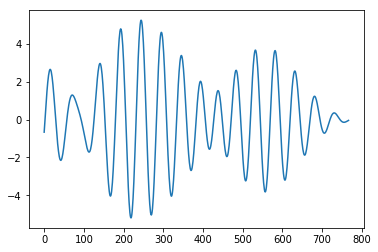

In [58]:
plt.plot(EEG_filt_FB_go[1][0][0])